In [1]:
library(tidyverse)
library(broom)
library(gtsummary)
library(flextable)
library(gt)
library(caret)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘flextable’


The following object is masked from ‘package:gtsummary’:

    as_flextable


The following object is masked from ‘package:purrr’:

    compose


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



# Introduction
In this assignment you will practice using some basic machine learning methods and concepts discussed so far in lecture to develop prediction algorithms from real-world public health datasets.  You will predict a continuous outcome first, followed by a binary outcome ("Yes" or "No), using K-nearest neighbor, linear regression, and logistic regression

# 1
## Setup
In the first part, you will work with cancer mortality data in the United States at the county level from 2010-2016, with demographic information on the counties from 2013 US Census estimates.

The outcome of interest in the data is mean yearly per capita (100,000 people) cancer mortalities from 2010-2016, denoted `TARGET_deathRate` in the dataset (`cancer_reg.csv`).  So more info on the dataset in the docs folder.  

## A
First, let's look at summary statistics of the variables of interest in the data using the function `tbl_summary` in the `gtsummary` package.  Be sure to print the table as a `flextable` using the function `as_flex_table`.  Specifically:

- First, create variable `deathrate_vs_median` in dataset after reading in CSV
  - `deathrate_vs_median`="No" if `TARGET_deathRate`< `median(TARGET_deathRate)`
  - ="Yes" otherwise
- Provide stats for the following variables:
  -`TARGET_deathRate`, `medIncome`, `povertyPercent`, `MedianAge`, `PctPrivateCoverage`, `PctPublicCoverage`, `PctWhite`, `PctBlack`, `PctAsian`, `PctOtherRace`
  - **NOTE**: Don't remove variables from dataset to only those marked above.  Only use functions in `gtsummary` to remove variables from table (see `include` argument)
  - Group the summary statistics by `deathrate_vs_median`
  - Include sample size $N$ using `add_n`
  - Add p-values from one-way ANOVA test for differences in variables between "No" and "Yes" groups of `TARGET_deathRate`
  - For all variables, provide mean and standard deviation (SD) as statistics
  - Add a gray background to the cells in the row corresponding to `TARGET_deathRate`
    - **Hint**: Look at changing row/column background color in `flextable` package after using
    `as_flex_table` function
  - Also, bold text in header row after using `as_flex_table`

In [2]:
#setting working directory
setwd('/Users/alexis/Documents/BIOS 635/Assignment 2/data')

#reading in data
cancer_df = read_csv('cancer_reg.csv')
diabetes_df = read_csv('diabetes.csv') 

#creating a col to see if the cancer death rate for each county is greater than the median
cancer_df = cancer_df %>% 
  mutate(deathrate_vs_median = ifelse(TARGET_deathRate < median(TARGET_deathRate) ,'No', 'Yes')) #no = GOOD!, yes = BAD!
  
#making flextable
ft = cancer_df %>%
  tbl_summary(by = deathrate_vs_median, 
              include = c("TARGET_deathRate", "medIncome", "povertyPercent", "MedianAge", 
                          "PctPrivateCoverage", "PctPublicCoverage",  "PctWhite", "PctBlack", "PctAsian", "PctOtherRace",
                          "deathrate_vs_median"),
              missing = "no", statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% #adding p value from anova
  as_flex_table() 

ft = bg(ft, bg = "gray", i = 1) #making the first row gray
ft = bold(ft, part = "header") #bolding header
ft


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  binnedInc = col_character(),
  Geography = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  Pregnancies = col_double(),
  Glucose = col_double(),
  BloodPressure = col_double(),
  SkinThickness = col_double(),
  Insulin = col_double(),
  BMI = col_double(),
  DiabetesPedigreeFunction = col_double(),
  Age = col_double(),
  Outcome = col_double()
)




a flextable object.
col_keys: `label`, `n`, `stat_1`, `stat_2`, `p.value` 
header has 1 row(s) 
body has 10 row(s) 
original dataset sample: 
               label     n          stat_1         stat_2 p.value
1   TARGET_deathRate 3,047        157 (16)       200 (19)  <0.001
2          medIncome 3,047 51,686 (13,097) 42,461 (8,725)  <0.001
3     povertyPercent 3,047          15 (6)         19 (6)  <0.001
4          MedianAge 3,047     45.3 (45.7)    45.3 (45.0)    >0.9
5 PctPrivateCoverage 3,047         68 (11)         61 (9)  <0.001

## B
Now, let's do some data visualization.  

Let's look at some 2-dimensional scatterplots of some of the above variables to assess correlation.  Specifically, recreate the following matrix of scatterplots:

- Look at the following variables
  - Use `ggpairs` from the `GGally` package:     
    - https://www.r-graph-gallery.com/199-correlation-matrix-with-ggally.html
  - `medIncome`, `povertyPercent`, `PctPrivateCoverage`, `PctPublicCoverage`
  - Color points by `deathrate_vs_median`
  - Provide some interpretation of the relationships you see in the figure.  Specifically:
    - Are there variables that have high correlations?
      - Do these high correlations make sense conceptually?
    - Compare the distributions of the variables between the two mortality rate groups (see diagonal).

<b> Answer </b>
Based on what I've learned from my first biostatistics class, we consider anything with a correlation coefficent > 0.7 to be highly correlated. In the plot below, that includes the following correlations:
- Overall
  - Poverty & Median Income
  - Private Coverage & Median Income
  - Public Coverage & Median Income
  - Private Coverage & Poverty
  - Public Coverage & Private Coverage
- Below Median Mean per capita Cancer Mortality (encoded as "Yes")
  - Poverty & Median Income
  - Private Coverage & Median Income
  - Public Coverage & Median Income
  - Private Coverage & Poverty
  - Public Coverage & Private Coverage
- Above Median Mean per capita Cancer Mortality (encoded as "No")
  - Poverty & Median Income
  - Public Coverage & Median Income
  - Private Coverage & Poverty
  
  
These correlations make sense conceptually, because higher paying jobs tend to have better private healthcare options and coverage. The diagonal represents the distribution of each variable stratified by "deathrate_vs_median". So, overall we can see that counties with a mean per capita cancer mortality greater than the median for all counties have higher rates of poverty and goverment-provided healthcare, while having lower rates of median income and private healthcare. 

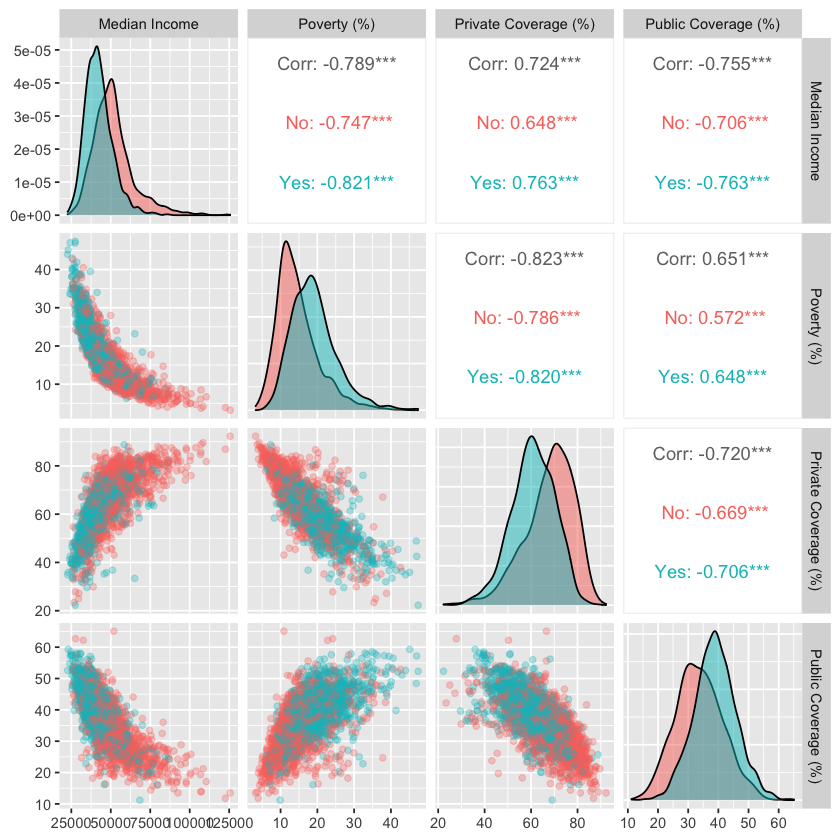

In [3]:
ggpairs(cancer_df%>%
  #slecting all the data needed for the plots
  select(medIncome, povertyPercent, PctPrivateCoverage, PctPublicCoverage, deathrate_vs_median), 
        #only choosing first 4 columns to display
        columns = 1:4,
        #color by deathrate_vs_median
        ggplot2::aes(color = deathrate_vs_median),
        diag = list(discrete = "barDiag", continuous = wrap("densityDiag", alpha = 0.5)), #adding transparency to diagonal
        lower = list(continuous = wrap("points", alpha = 0.3), discrete = "blank", combo="blank"), #adding transparency to scatterplot
        columnLabels = c("Median Income", "Poverty (%)", "Private Coverage (%)", "Public Coverage (%)"))

## C
Now, let's begin to create our prediction algorithms for `TARGET_deathRate`.  First, we will start with using K-nearest neighbor (KNN).

Let's consider the features included in our summary statistics table (`TARGET_deathRate`, `medIncome`, `povertyPercent`, `MedianAge`, `PctPrivateCoverage`, `PctPublicCoverage`, `PctWhite`, `PctBlack`, `PctAsian`, `PctOtherRace`).  

- First, we will split our data into separate training and testing sets (60% in training and 40% in testing) randomly.  
- Next, train a KNN algorithm on the training dataset.
  - Use `train` function in `caret` function (see lecture slides).  Use `tuneLength`=20 and center and scale the features (see `preProcess` argument).
  - Leave everything else at default.  What is the "best" tuning parameter value chosen for parameter $k$?
  What criteria is used by R to select this "best" parameter?
  - Plot the RMSE for each considered value of $k$ during the tuning process.  What does $k$ represent based on the plot (**Hint**: see lecture slides and x-axis of plot)
- Lastly, test your algorthim at this "best" tuning parameter value on the test set.  Print out the test set performance based on RMSE, $R^2$, and MAE using `flextable`

<b> Answer </b>
The best tuning parameter is k = 43 and the lowest root mean squared error is used to find the best tuning parameter. Based on the plot, k is the number of nearest neighbors.  

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


k-Nearest Neighbors 

1830 samples
   9 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1830, 1830, 1830, 1830, 1830, 1830, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared    MAE     
   5  28.75924  0.07915240  21.87622
   7  27.81163  0.09203467  21.13764
   9  27.16083  0.10540807  20.66236
  11  26.70468  0.11535739  20.30006
  13  26.39013  0.12370580  20.05417
  15  26.09354  0.13374493  19.80187
  17  25.89560  0.14074446  19.65314
  19  25.76389  0.14554280  19.54177
  21  25.62079  0.15146141  19.43995
  23  25.52976  0.15488438  19.38134
  25  25.43128  0.15917878  19.31174
  27  25.33701  0.16387628  19.24222
  29  25.27743  0.16665114  19.18275
  31  25.21832  0.16916290  19.13966
  33  25.16298  0.17181051  19.10422
  35  25.13842  0.17311999  19.07886
  37  25.11383  0.17410562  19.06013
  39  25.09413  0.17505617  19.04945
  41  25.05475  0.17718553  19.01985
  43  25.01264  0.17938479  18.98506

RMSE 

a flextable object.
col_keys: `RMSE`, `Rsquared`, `MAE` 
header has 1 row(s) 
body has 1 row(s) 
original dataset sample: 
      RMSE  Rsquared      MAE
1 25.03965 0.2022299 18.67384

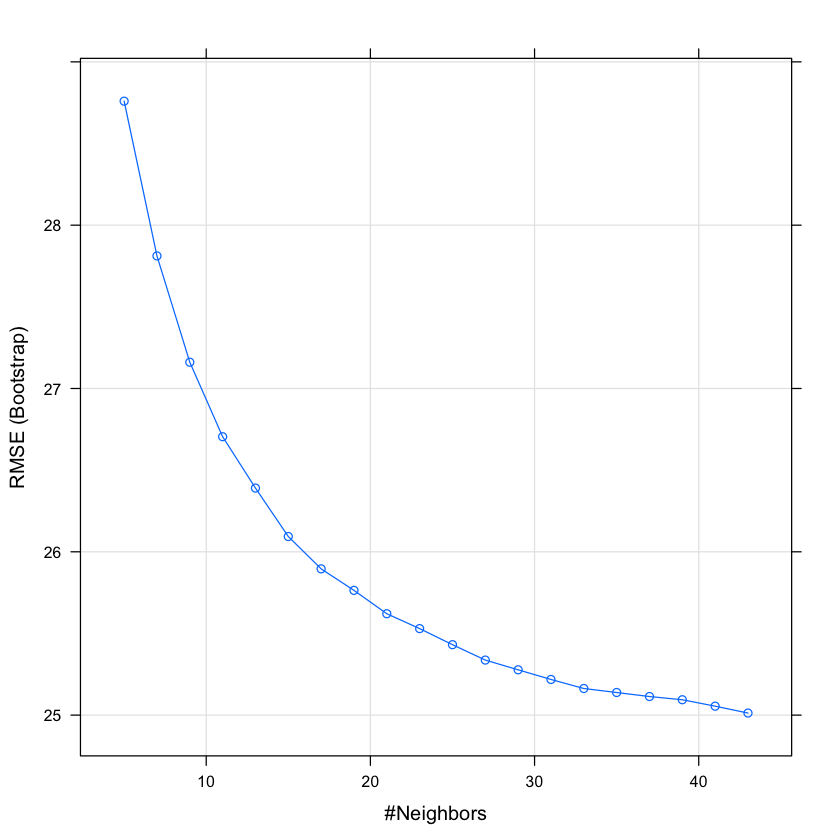

In [4]:
set.seed(12) # Setting seed for reproducibility

#only including variables of interest
cancer_small_df = cancer_df %>%
  select("TARGET_deathRate", "medIncome", "povertyPercent", "MedianAge", "PctPrivateCoverage", "PctPublicCoverage",  "PctWhite", "PctBlack", "PctAsian", "PctOtherRace")
#splitting data into training and testing sets
cancer_df_index = createDataPartition(cancer_small_df$TARGET_deathRate, p = 0.6, list = FALSE)
cancer_train = cancer_small_df[cancer_df_index,]
cancer_test = cancer_small_df[-cancer_df_index,]

#training algorithm 
knn_cancer = train(TARGET_deathRate ~ ., data = cancer_train, method = 'knn', tuneLength = 20)
knn_cancer

#plotting 
plot(knn_cancer)

#testing algorithm
knn_pred_deathrate = predict(knn_cancer, newdata = cancer_test)
diff = knn_pred_deathrate - cancer_test$TARGET_deathRate

#first making empty df for values to go into 
table = data.frame(array(0, dim = c(1,3))) #making array with zeros
colnames(table) = c("Root Mean Square Error", "R^2", "Mean Absolute Error")
table$`Root Mean Square Error` = round(sqrt(mean((diff)^2)), 7)
table$`R^2` = 1 - (sum((diff)^2) / sum((cancer_test$TARGET_deathRate - mean(cancer_test$TARGET_deathRate))^2))
table$`Mean Absolute Error` = mean(abs(diff))

#making table
#table %>%
#  flextable()

#assessing prediction (made my life easier by using postResample function instead calculating each value separately)
test_performance = postResample(knn_pred_deathrate, cancer_test$TARGET_deathRate)
data.frame(t(test_performance)) %>%
  flextable()

## D
### I
Let's next move to a linear regression model for prediction.  We consider the same features listed in 1c with the same outcome variable.

- Use the same training and testing sets created in 1c
- Train a linear regression algorithm with all of the above features.  Print out the following results:
  - Coefficient estimate table from `summary` function (estimate, standard error, test statistic, p-value)
    - Create this table using the `tidy` function from `broom` and print out using `flextable`
  - Evaluate the following assumptions using the corresponding visual
    - 1. Homoskedasicity (fitted value by residual plot)
    - 2. Normality (QQ plot of residuals vs theoretical normal distribution)
  - One may argue that normally distributed residuals are not a concern for this dataset.  Why?
  - One common belief in regression is that your **outcome** is assumed to be normally distributed.  Why is
  this incorrect?
  
<b> Answer </b>
A linear regression assumes that homoscedasticity, independent residuals, and normally distributed residuals or the large sample approximation is being met. Since the Scale-Location plot isn't a horizontal line with equally spread points, we can't assume homoscedasticity for this dataset. Since the Q-Q plot follow the dashed line reasonably well, we can assume the residuals are normally distributed.

a flextable object.
col_keys: `term`, `estimate`, `std.error`, `statistic`, `p.value` 
header has 1 row(s) 
body has 10 row(s) 
original dataset sample: 
                term      estimate    std.error statistic p.value
1        (Intercept)  1.810198e+02 1.544043e+01 11.723751  <0.005
2          medIncome -1.542454e-04 1.022633e-04 -1.508316    0.13
3     povertyPercent  5.295673e-01 2.083741e-01  2.541425    0.01
4          MedianAge -1.419955e-02 1.188018e-02 -1.195230    0.23
5 PctPrivateCoverage -4.048070e-01 1.152003e-01 -3.513939  <0.005

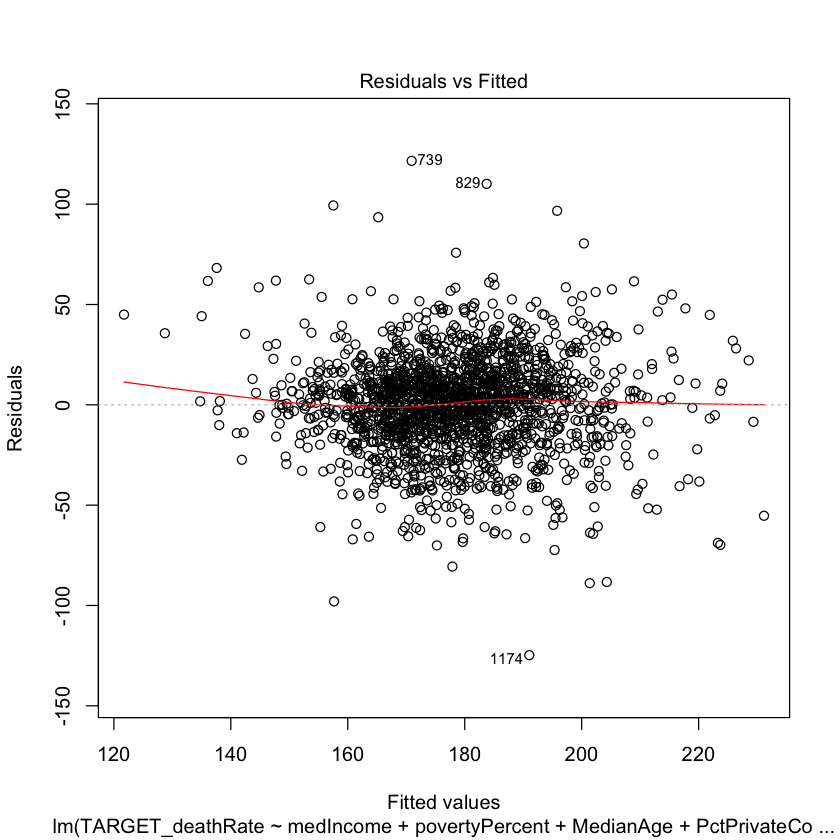

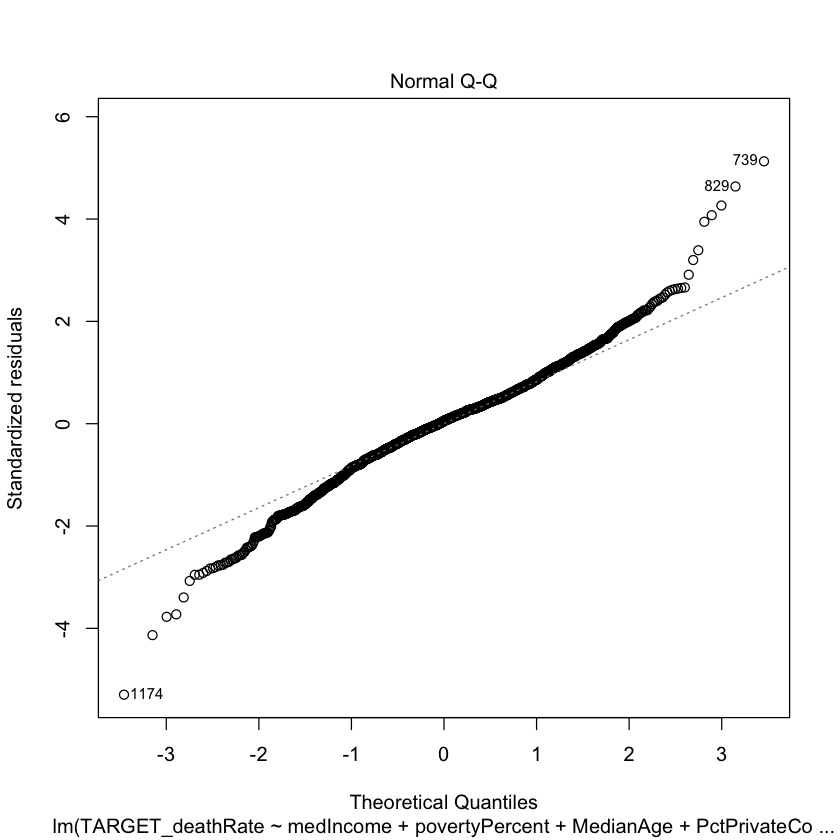

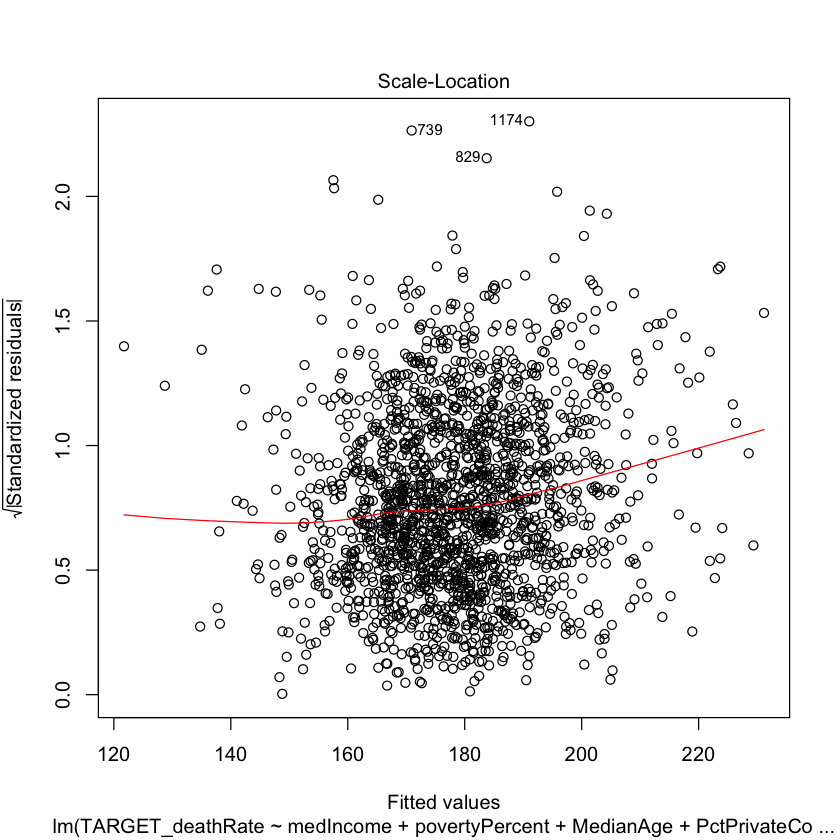

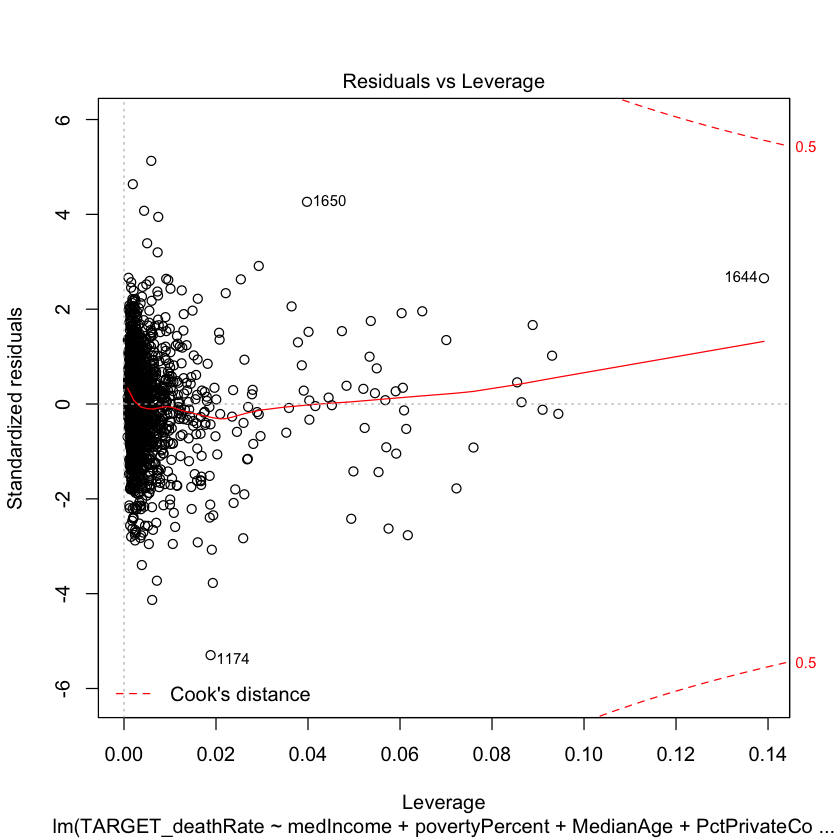

In [5]:
#linear regression algorithm
lm_train = lm(formula = TARGET_deathRate ~ medIncome + povertyPercent + MedianAge + PctPrivateCoverage + PctPublicCoverage + PctWhite + PctBlack + PctAsian + PctOtherRace, data = cancer_train) 

#making table based on the regression
tidy(lm_train) %>%
  mutate(p.value = ifelse(p.value < 0.005, "<0.005",
                          as.character(round(p.value, 2)))) %>%
  flextable()

#testing for homoscedasticity/normality
plot(lm_train)

### II
- Test the algorithm developed in the previous step on the test dataset.  Print out the following in a `flextable`
  - Test set RMSE, $R^2$, adjusted $R^2$, and MAE
- In a separate `flextable`, print out these same metrics based on the performance in the training set
  - Evaluate the differences between the training and testing performance
- Based on your plots in 1b, do you have any concerns about collinearity?  If so, how would you change the set of feature variable used to fix this concern?  How did you choose this set?
  - **Note**: you don't need to actually re-run the regression analysis with this reduced set of features
  
<b> Answer </b>
Multicollinearilty is definitely a concern, because many of the covariates have high levels of correlations between them. Therefore, I would remove median income, poverty, and private coverage from the linear model. These were chosen due to the highest pearson's correlation coefficients. 

In [6]:
#testing algorithm
lm_pred_deathrate = predict(lm_train, newdata = cancer_test)

#assessing prediction (made my life easier by using postResample function instead calculating each value separately)
test_performance = postResample(lm_pred_deathrate, cancer_test$TARGET_deathRate)
data.frame(t(test_performance)) %>%
  flextable()

a flextable object.
col_keys: `RMSE`, `Rsquared`, `MAE` 
header has 1 row(s) 
body has 1 row(s) 
original dataset sample: 
      RMSE  Rsquared      MAE
1 24.24253 0.2522902 18.02656

# 2
## Setup
In the second part, you will work with diabetes incidence data in the US, composed of Native American, female hospital patients at 21 years old.

The outcome of interest, `Outcome` in the data is binary indicator if the patient has a diagnosis of diabetes (0 = "No", 1 = "Yes").  You will try to predict this outcome based on patient traits as features.  See the docs folder for more information.  The dataset is called `diabetes_data.csv`.

## A
First, let's look at summary statistics of the variables of interest in the data using the function `tbl_summary` in the `gtsummary` package.  Be sure to print the table as a `flextable` using the function `as_flex_table`.  Specifically:

- Provide stats for the following variables:
  - `Pregnancies`, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, `Age`
  - **NOTE**: Don't remove variables from dataset to only those marked above.  Only use functions in `gtsummary` to remove variables from table (see `include` argument)
  - Group the summary statistics by `Outcome`
  - Include sample size $N$ using `add_n`
  - Add p-values from one-way ANOVA test for differences in variables between groups of `Outcome`
  - For all variables, provide mean and standard deviation (SD) as statistics
  - Also, bold text in header row after using `as_flex_table`

In [7]:
#making flextable
ft = diabetes_df %>%
  tbl_summary(by = Outcome, missing = "no", 
  include = c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "Age", "Outcome"),
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% #adding p value from anova
  as_flex_table() 

ft = bold(ft, part = "header") #bolding header
ft

a flextable object.
col_keys: `label`, `n`, `stat_1`, `stat_2`, `p.value` 
header has 1 row(s) 
body has 7 row(s) 
original dataset sample: 
          label   n    stat_1    stat_2 p.value
1   Pregnancies 768 3.3 (3.0) 4.9 (3.7)  <0.001
2       Glucose 768  110 (26)  141 (32)  <0.001
3 BloodPressure 768   68 (18)   71 (21)   0.072
4 SkinThickness 768   20 (15)   22 (18)   0.038
5       Insulin 768   69 (99) 100 (139)  <0.001

## B
Now, let's begin to create our prediction algorithms for `Outcome`.  First, we will start with using K-nearest neighbor (KNN).

Let's consider the features included in our summary statistics table (`Pregnancies`, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, `Age`).  

- First, we will split our data into separate training and testing sets (60% in training and 40% in testing) randomly.  
- Next, train a KNN algorithm on the training dataset.
  - Use `train` function in `caret` function (see lecture slides).  Use `tuneLength`=20 and center and scale the features (see `preProcess` argument).
  - Leave everything else at default.  What is the "best" tuning parameter value chosen for parameter $k$?
  What criteria is used by R to select this "best" parameter?
  - Plot the Prediction Accuracy for each considered value of $k$ during the tuning process.  What does $k$ represent based on the plot (**Hint**: see lecture slides and x-axis of plot)
- Lastly, test your algorithm at this "best" tuning parameter value on the test set.  Print out the test set performance based on Prediction Accuracy, Sensitivity, Specificity, PPV, and NPV using `flextable`.
  - **Hint**: Use `confusionMatrix` function in `caret` package.  Then convert to data frame to print as
  `flextable`

<b> Answer </b>
The best tuning parameter is k = 29 and the highest accuracy value is used to find the best tuning parameter. Based on the plot, k is the number of nearest neighbors.  

k-Nearest Neighbors 

461 samples
  7 predictor
  2 classes: '0', '1' 

Pre-processing: centered (7), scaled (7) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 461, 461, 461, 461, 461, 461, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.7342591  0.4016472
   7  0.7371905  0.4057346
   9  0.7380890  0.4027888
  11  0.7451981  0.4122451
  13  0.7466398  0.4117471
  15  0.7489824  0.4151190
  17  0.7417889  0.3953587
  19  0.7458977  0.4016333
  21  0.7418156  0.3864073
  23  0.7426074  0.3848980
  25  0.7431282  0.3839740
  27  0.7467009  0.3932664
  29  0.7504795  0.3994081
  31  0.7446012  0.3829996
  33  0.7458380  0.3829874
  35  0.7435054  0.3767698
  37  0.7404778  0.3681056
  39  0.7427576  0.3730146
  41  0.7406612  0.3657590
  43  0.7391005  0.3610565

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 29.

a flextable object.
col_keys: `Accuracy`, `Sensitivity`, `Specificity`, `Pos.Pred.Value`, `Neg.Pred.Value` 
header has 1 row(s) 
body has 1 row(s) 
original dataset sample: 
   Accuracy Sensitivity Specificity Pos.Pred.Value Neg.Pred.Value
1 0.7068404       0.825   0.4859813           0.75      0.5977011

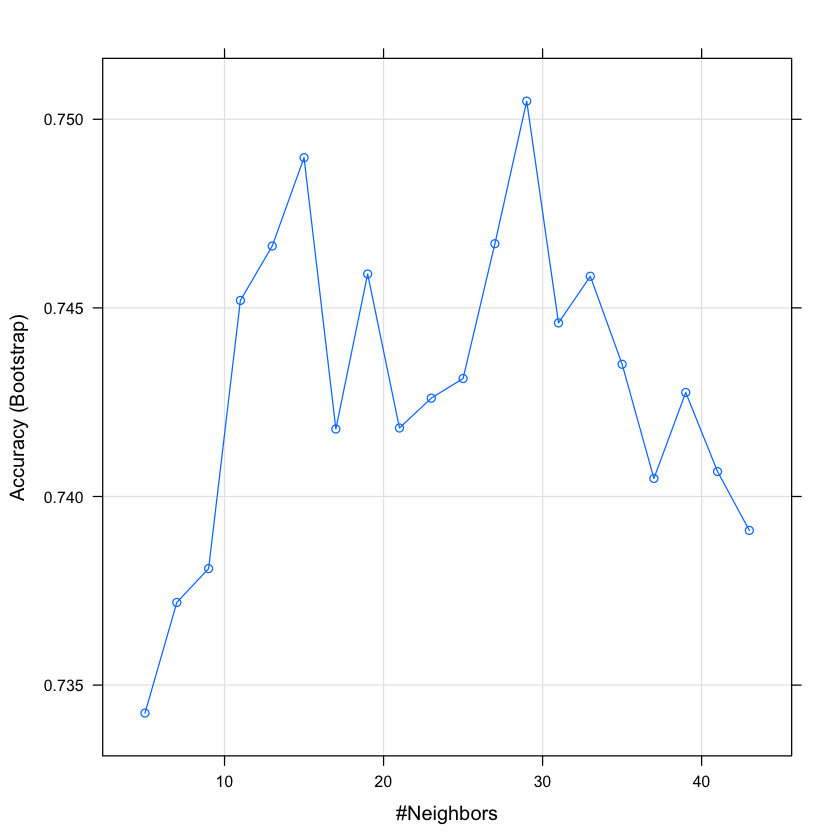

In [8]:
set.seed(12) # Setting seed for reproducibility

#only including variables of interest
diabetes_df$Outcome = factor(diabetes_df$Outcome) #need to first convert this to a factor for the train function to work
diabetes_small_df = diabetes_df %>%
  select(Outcome, Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, Age)

#splitting data into training and testing sets
diabetes_df_index = createDataPartition(diabetes_small_df$Outcome, p = 0.6, list = FALSE)
diabetes_train = diabetes_small_df[diabetes_df_index,]
diabetes_test = diabetes_small_df[-diabetes_df_index,]

#training algorithm 
knn_diabetes = train(Outcome ~ ., data = diabetes_train, method = 'knn', tuneLength = 20, preProcess = c("center","scale"))
knn_diabetes

#plotting 
plot(knn_diabetes)

# testing algorithm and making flextable
matrix = confusionMatrix(predict(knn_diabetes, newdata = diabetes_test), diabetes_test$Outcome)
ft = data.frame(t(c(matrix$overall[1], matrix$byClass[1:4]))) %>% #extracting accuracy, sens, spec, PPV, NPV
  flextable()
ft

## C
Finally, we will end with using logistic regression.  We consider the same features listed in 2b with the same outcome variable.

- Train a logistic regression algorithm with all of the above features.  Print out the following results:
  - Coefficient estimate table from `summary` function (estimate, standard error, test statistic, p-value)
    - Create this table using the `tidy` function from `broom` and print out using `flextable`
  - Print out the test set performance based on Prediction Accuracy, Sensitivity, Specificity, PPV, and NPV using `flextable`.
    - **Hint**: Use `confusionMatrix` function in `caret` package.  Then convert to data frame to print as
  `flextable`

In [9]:
set.seed(12) # Setting seed for reproducibility

#logistic regression algorithm
log_train = glm(formula = Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + Age, family = binomial(), data = diabetes_train) 

#raw output
#summary(log_train)

#estimate table 
tidy(log_train) %>%
  mutate(p.value = ifelse(p.value<0.005, "<0.005",
  as.character(round(p.value, 3))),
  term = fct_recode(factor(term),
  "Intercept"="(Intercept)",
  "Max Heart Rate"=
  "MAX_Heart_Rate")) %>%
  flextable() %>%
  set_header_labels("term" = "Variable",
  "estimate" = "Estimate",
  "std.error" = "Std. Error",
  "statistic" = "Z Statistic",
  "p.value" = "P-value") %>%
  autofit()


#performance assessment table of algorithm and making flextable
#making the prediction binary
diabetes_test$Pred = predict(log_train, newdata = diabetes_test)
diabetes_test = diabetes_test %>%
  mutate(Pred = relevel(factor(ifelse(Pred > 0, "1", "0")),
                                 ref = "0"))

matrix = confusionMatrix(data = diabetes_test$Pred, reference = diabetes_test$Outcome, positive = "1")
ft = data.frame(t(c(matrix$overall[1], matrix$byClass[1:4]))) %>% #extracting accuracy, sens, spec, PPV, NPV
  flextable()
ft

Warning message:
“Unknown levels in `f`: MAX_Heart_Rate”


a flextable object.
col_keys: `term`, `estimate`, `std.error`, `statistic`, `p.value` 
header has 1 row(s) 
body has 8 row(s) 
original dataset sample: 
           term     estimate   std.error  statistic p.value
1     Intercept -9.794176721 1.014123989 -9.6577705  <0.005
2   Pregnancies  0.127965205 0.043624506  2.9333330  <0.005
3       Glucose  0.041023547 0.005055629  8.1144292  <0.005
4 BloodPressure -0.015867075 0.007234540 -2.1932391   0.028
5 SkinThickness  0.004999058 0.009215841  0.5424419   0.588

a flextable object.
col_keys: `Accuracy`, `Sensitivity`, `Specificity`, `Pos.Pred.Value`, `Neg.Pred.Value` 
header has 1 row(s) 
body has 1 row(s) 
original dataset sample: 
  Accuracy Sensitivity Specificity Pos.Pred.Value Neg.Pred.Value
1 0.732899   0.5700935        0.82       0.628866      0.7809524